In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import plotly.express as px
from platypus import Problem, EpsNSGAII, Real, ProcessPoolEvaluator
from platypus import (Solution, EpsilonBoxArchive, GenerationalDistance, InvertedGenerationalDistance,
                      Hypervolume, EpsilonIndicator, Spacing)
import pickle

import csv
import logging
from itertools import chain
logging.basicConfig(level=logging.INFO)

In [2]:
# change directory to model location
os.chdir("..") 
from susquehanna_model import susquehanna_model

In [3]:
# load variables
varlist = []
variables = []
for filename in os.listdir('output'):
    if filename.endswith('variables.csv'):
        varlist.append(filename[:-4])
        df_temp = pd.read_csv(f"output/{filename}", header=None)
        variables.append(df_temp.values.tolist())
print(f"Loaded: {', '.join(varlist)}")
variables = list(chain.from_iterable(variables))

Loaded: SquaredExponential_10_variables


In [4]:
# Run model with found solution variables

# def model(RBFType, variables):
RBFType = "se" # RBF
numberOfInput = 3 # (time, storage of Conowingo)
numberOfOutput = 4  # Atomic, Baltimore,Chester, Downstream:- hydropower, environmental
numberOfRBF = 5  # numberOfInput + 2

# Initialize model
nobjs = 6
nvars = 40
n_years = 1
susquehanna_river = susquehanna_model(108.5, 505.0, 5, n_years)  # l0, l0_MR, d0, years
# l0 = start level cono, l0_MR = start level muddy run, d0 = startday > friday = 5
susquehanna_river.load_data(0)  # 0 = historic, 1 = stochastic
susquehanna_river.set_log(True)
susquehanna_river.setRBF(numberOfRBF, numberOfInput, numberOfOutput, RBFType)

# for solution in algorithm.result:
#     susquehanna_river.evaluate(solution.variables)
for nvars in variables:
    susquehanna_river.evaluate(nvars)
    
level_CO, level_MR, ratom, rbalt, rches, renv = susquehanna_river.get_log()
#     return level_CO, level_MR, ratom, rbalt, rches, renv

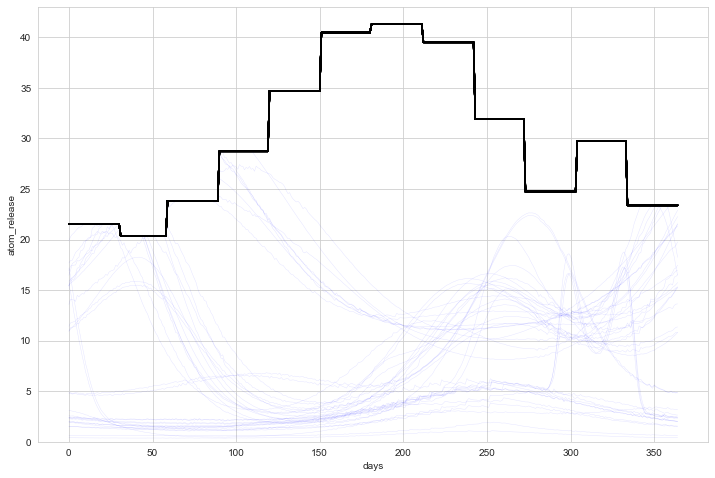

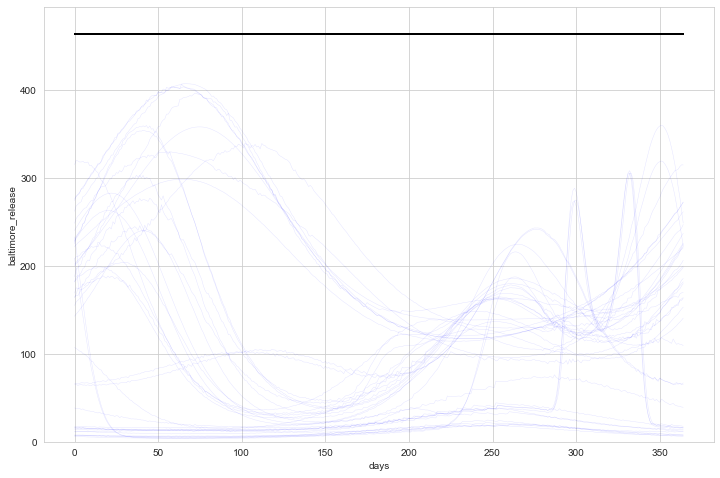

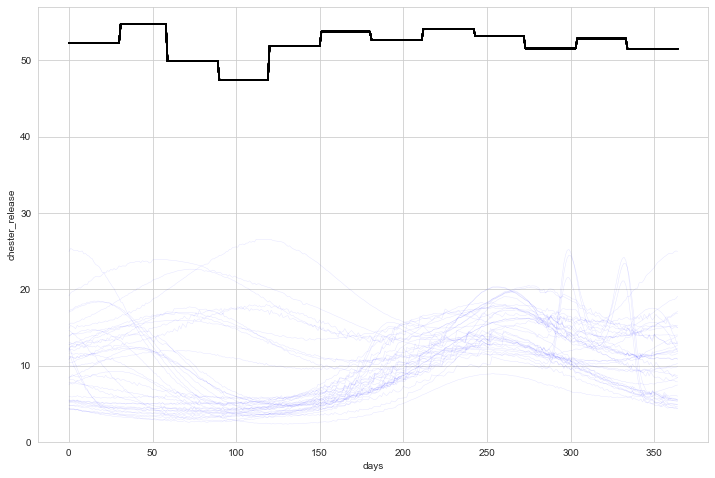

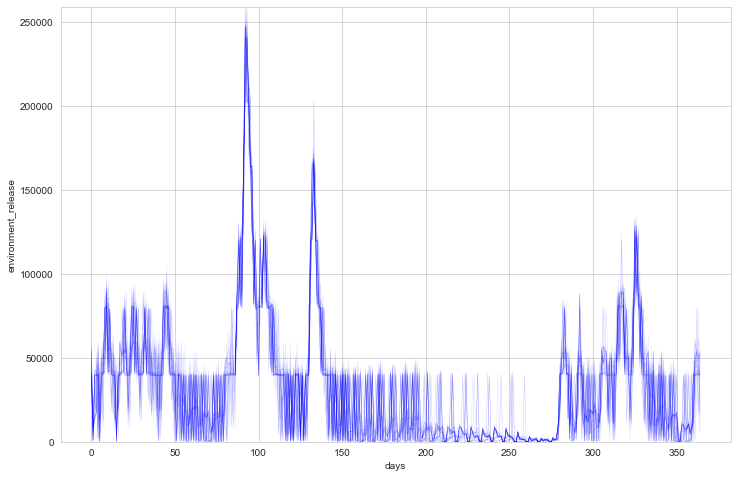

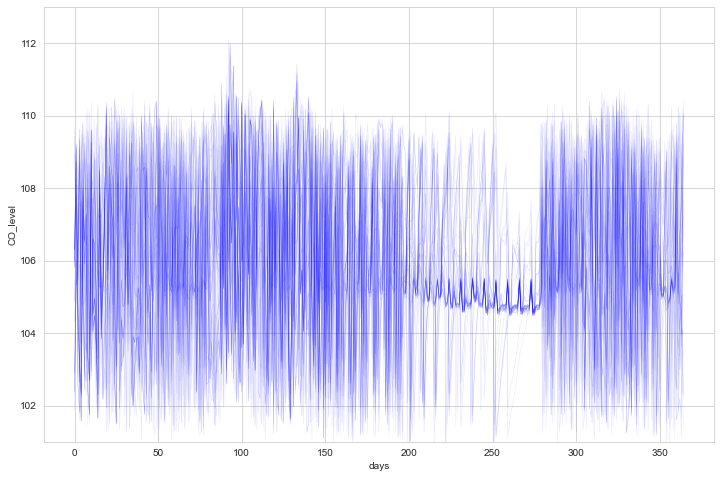

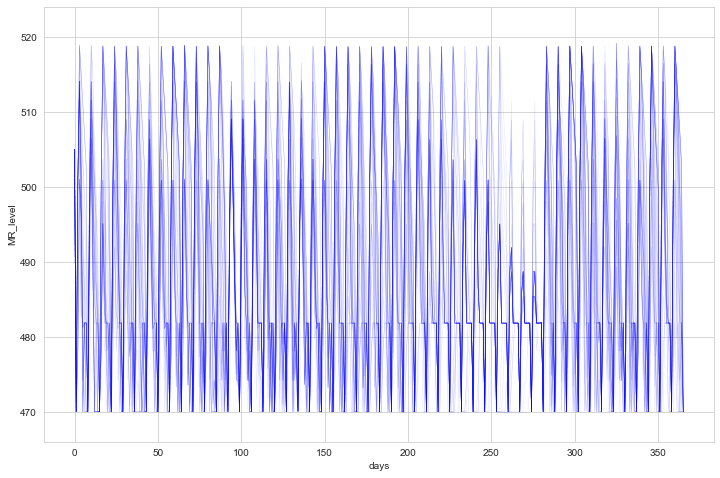

In [5]:
# load demand
for filename in os.listdir('data1999'):
    if filename.startswith('w'):
        globals()[f"{filename[:-4]}"] = np.loadtxt(f'data1999/{filename}')

# plot releases and basins
alpha = 0.1
lw = 0.5
color = "blue"
for release in ratom:
   plot = plt.plot(release, color, linewidth=lw, alpha=alpha)
   plot = plt.plot(wAtomic, "black") 
   plot = plt.xlabel('days')
   plot = plt.ylabel('atom_release')
   plot = plt.ylim((0, 43))
plt.show()

for release in rbalt:
   plot = plt.plot(release, color, linewidth=lw, alpha=alpha)
   plot = plt.plot(wBaltimore, "black")
   plot = plt.xlabel('days')
   plot = plt.ylabel('baltimore_release')
   plot = plt.ylim((0, 495))
plt.show()

for release in rches:
   plot = plt.plot(release, color, linewidth=lw, alpha=alpha)
   plot = plt.plot(wChester, "black")
   plot = plt.xlabel('days')
   plot = plt.ylabel('chester_release')
   plot = plt.ylim((0, 57))
plt.show()

for release in renv:
   plot = plt.plot(release, color, linewidth=lw, alpha=alpha)
   plot = plt.xlabel('days')
   plot = plt.ylabel('environment_release')
   plot = plt.ylim((0, 259000))
plt.show()

for year in level_CO:
   plot = plt.plot(year, color, linewidth=lw, alpha=alpha)
   plot = plt.xlabel('days')
   plot = plt.ylabel('CO_level')
   plot = plt.ylim((101, 113))
plt.show()

for year in level_MR:
   plot = plt.plot(year, color, linewidth=lw, alpha=alpha)
   plot = plt.xlabel('days')
   plot = plt.ylabel('MR_level')
   plot = plt.ylim((466, 524))
plt.show()

In [ ]:
# load objectives
objlist = []
objectives = []
for filename in os.listdir('output'):
    if filename.endswith('solution.csv'):
        objlist.append(filename[:-4])
        df_temp = pd.read_csv(f"output/{filename}", header=0)
        objectives.append(df_temp.values.tolist())
print(f"Loaded: {', '.join(objlist)}")
objectives = list(chain.from_iterable(objectives))

In [ ]:
# parcoords plot objectives
dfl = []
for i in objectives:
    dfl.append(tuple(i))
df = pd.DataFrame(dfl, columns=['Hydropower', 'AtomicPowerplant', 'Baltimore', 'Chester', 'Environment', 'Recreation'])
df = df * -1
colors = []
for i in range(len(df)):
    colors.append(i)
fig = px.parallel_coordinates(df, color="Hydropower")
fig.show()

In [8]:
np.asarray(variables)[:, 48::]

array([[1.34755814, 3.75788431],
       [1.62118371, 3.26645667],
       [1.3165174 , 2.81627578],
       [1.33868118, 3.2653274 ],
       [1.3165174 , 2.81627578],
       [1.33785091, 2.84004108],
       [1.67839459, 3.25145681],
       [1.30248093, 3.26645039],
       [1.23933362, 3.25563023],
       [1.33611939, 3.26989421],
       [1.20313949, 3.86987673],
       [2.66625181, 3.76363266],
       [1.27398358, 3.12587118],
       [1.28559663, 2.81628953],
       [1.3165174 , 2.81627578],
       [1.21468235, 3.26646698],
       [1.24855595, 2.81627578],
       [1.25341287, 3.74801702],
       [1.34090549, 3.17380782],
       [1.20211324, 3.27044328],
       [1.33512614, 3.09269157],
       [1.33868118, 3.18542343],
       [1.31793488, 2.81627578],
       [1.32106615, 3.26478053],
       [1.20211324, 3.28171923],
       [1.33955622, 3.15216664],
       [1.29790196, 3.26478053],
       [1.51475565, 3.27046797],
       [1.28235667, 3.07460207],
       [1.47186945, 3.26646138],
       [2.